In [1]:
import os
import pathlib
import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import nvitop
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, RMSprop

# os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [2]:
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [3]:
datadir = pathlib.Path(
    r"C:\Users\josephdavis\Desktop\Tensorflow notebooks\cats-v-dogs\training"
)
valdir = pathlib.Path(
    r"C:\Users\josephdavis\Desktop\Tensorflow notebooks\cats-v-dogs\testing"
)

AUTOTUNE = tf.data.AUTOTUNE

logdir = pathlib.Path.cwd() / "logs"

if len(os.listdir(logdir)) > 5:
    shutil.rmtree(logdir)

In [4]:
# import os
# import cv2
# from PIL import Image
# def check_images( s_dir, ext_list):
#     bad_images=[]
#     bad_ext=[]
#     s_list= os.listdir(s_dir)
#     for klass in s_list:
#         klass_path=os.path.join (s_dir, klass)
#         print ('processing class directory ', klass)
#         if os.path.isdir(klass_path):
#             file_list=os.listdir(klass_path)
#             for f in file_list:
#                 f_path=os.path.join (klass_path,f)
#                 index=f.rfind('.')
#                 ext=f[index+1:].lower()
#                 if ext not in ext_list:
#                     print('file ', f_path, ' has an invalid extension ', ext)
#                     bad_ext.append(f_path)
#                     os.remove(f_path)
#                     print("removed bad extension file")
#                 if os.path.isfile(f_path):
#                     try:
#                         img=cv2.imread(f_path)
#                         shape=img.shape
#                     except:
#                         print('file ', f_path, ' is not a valid image file')
#                         bad_images.append(f_path)
# #                         img = Image.open(f_path)
# #                         img = img.save(f_path + ".jpeg")
#                         os.remove(f_path)
#                         print('Removed bad image')
#                 else:
#                     print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
#         else:
#             print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
#     return bad_images, bad_ext
# ext_list = ["jpg"]
# check_images(datadir, ext_list)
# check_images(valdir, ext_list)

In [5]:
image_count = len(list(datadir.glob("*/*.jpg")))
print(image_count)
batch_size = 128
img_height = 150
img_width = 150

22283


In [6]:
list_ds = tf.data.Dataset.list_files(str(datadir / "*/*.jpg"), shuffle=False)
val_ds = tf.data.Dataset.list_files(str(valdir / "*/*.jpg"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
num_train_files = len(list_ds)
num_val_files = len(val_ds)

In [7]:
for f in list_ds.take(5):
    print(f.numpy())
print("validation")
for f in val_ds.take(5):
    print(f.numpy())

b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\training\\cats\\7973.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\training\\dogs\\10003.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\training\\cats\\11674.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\training\\dogs\\7023.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\training\\cats\\11055.jpg'
validation
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\testing\\cats\\100.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\testing\\cats\\10004.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\testing\\cats\\10024.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\testing\\cats\\10038.jpg'
b'C:\\Users\\josephdavis\\Desktop\\Tensorflow notebooks\\cats-v-dogs\\testing\\cats\\10052.jpg'


In [8]:
class_names = np.array(sorted([item.name for item in datadir.glob("*")]))
print(class_names)

['cats' 'dogs']


In [9]:
# val_size = int(image_count * .2)
# train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)
# train_ds = list_ds

In [10]:
print(tf.data.experimental.cardinality(list_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

22283
2473


In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [12]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    #     img = img/255.
    return img  # tf.image.resize(img, [img_height, img_width])

In [13]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #     return tf.data.Dataset.from_tensors((img, label))
    return img, label

In [14]:
train_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# train_ds = list_ds.interleave(
#     lambda x: tf.data.Dataset.list_files(str(datadir / "*/*.jpg"), shuffle=True),
#     num_parallel_calls=AUTOTUNE,
#     cycle_length=4,
# #     block_length=4,
# #     deterministic=False,
# ).map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.interleave(
#     lambda x: tf.data.Dataset.list_files(str(valdir / "*/*.jpg"), shuffle=True),
#     num_parallel_calls=AUTOTUNE,
#     cycle_length=4,
# #     block_length=4,
# #     deterministic=False,
# ).map(process_path, num_parallel_calls=AUTOTUNE)

# train_ds.cache()
# val_ds.cache()

In [15]:
# for image, label in train_ds.take(1):
#     print("Image Shape: ", image.numpy().shape)
#     print("Label: ", label.numpy())

In [16]:
data_augmentation = tf.keras.Sequential(
    [
        #         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        #         layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        layers.experimental.preprocessing.RandomRotation(0.2, interpolation="bilinear"),
        layers.experimental.preprocessing.RandomWidth(0.01, interpolation="bilinear"),
        layers.experimental.preprocessing.RandomHeight(0.01, interpolation="bilinear"),
        #         layers.experimental.preprocessing.RandomContrast(0.2),
        #         layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

resize_and_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(img_height, img_width),
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
    ]
)

In [17]:
def prepare(ds, shuffle=False, augment=False):

    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    ds.cache()

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        ).cache()

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

# options = tf.data.Options()
# options.experimental_threading.max_intra_op_parallelism = 1
# train_ds = train_ds.with_options(options)
# val_ds = val_ds.with_options(options)

In [18]:
# def prepare(ds, shuffle=False, augment=False):
#     # Resize and rescale all datasets
#     ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

#     if shuffle:
#         ds = ds.shuffle(1000)

#     # Batch all datasets
#     ds = ds.batch(batch_size)

#     # Use data augmentation only on the training set
#     if augment:
#         ds = ds.map(
#             lambda x, y: (data_augmentation(x, training=True), y),
#             num_parallel_calls=AUTOTUNE,
#         )
#     ds.cache()
#     # Use buffered prefecting on all datasets
#     return ds.prefetch(buffer_size=AUTOTUNE)


# train_ds = prepare(train_ds, shuffle=True, augment=True)
# val_ds = prepare(val_ds)

In [19]:
# def configure_for_performance(ds):
#     ds = ds.cache()
#     ds = ds.shuffle(buffer_size=1000)
#     ds = ds.batch(batch_size)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     return ds
# train_ds = configure_for_performance(train_ds)
# val_ds = configure_for_performance(val_ds)

In [20]:
# img_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(img_batch.numpy()[i])
#     label = label_batch[i]
#     plt.title(class_names[label])
#     plt.axis("off")

In [21]:
pre_trained_model = InceptionV3(
    input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet"
)

# weights_file = pathlib.Path.cwd() / 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)

model.compile(
    optimizer=RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"]
)

last layer output shape:  (None, 7, 7, 768)


In [22]:
# model = tf.keras.models.Sequential(
#     [
#         # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#         tf.keras.layers.Conv2D(
#             16, (3, 3), activation="relu", input_shape=(150, 150, 3)
#         ),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
#         tf.keras.layers.MaxPooling2D(2, 2),
# #         tf.keras.layers.Conv2D(512, (3, 3), activation="relu"),
# #         tf.keras.layers.MaxPooling2D(2, 2),
#         # Flatten the results to feed into a DNN
#         tf.keras.layers.Flatten(),
#         # 512 neuron hidden layer
#         tf.keras.layers.Dense(512, activation="relu"),
#         tf.keras.layers.Dense(64, activation="relu"),
#         # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
#         tf.keras.layers.Dense(1, activation="sigmoid"),
#     ]
# )

# model.compile(
#     optimizer=RMSprop(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"]
# )

# model.summary()

In [23]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch="500,520"
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="auto", patience=4, restore_best_weights=True
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    #     steps_per_epoch=100,
    #     validation_steps=50,
    verbose=1,
    callbacks=[callback, tboard_callback],
)

Epoch 1/50
175/175 [==============================] - 71s 360ms/step - loss: 0.4139 - accuracy: 0.8478 - val_loss: 0.1046 - val_accuracy: 0.9660
Epoch 2/50
175/175 [==============================] - 57s 327ms/step - loss: 0.1346 - accuracy: 0.9454 - val_loss: 0.1114 - val_accuracy: 0.9664
Epoch 3/50
175/175 [==============================] - 59s 336ms/step - loss: 0.0712 - accuracy: 0.9736 - val_loss: 0.1165 - val_accuracy: 0.9685
Epoch 4/50
175/175 [==============================] - 57s 327ms/step - loss: 0.0480 - accuracy: 0.9843 - val_loss: 0.1241 - val_accuracy: 0.9697
Epoch 5/50
175/175 [==============================] - 57s 328ms/step - loss: 0.0302 - accuracy: 0.9891 - val_loss: 0.1614 - val_accuracy: 0.9672
Epoch 6/50
175/175 [==============================] - 57s 328ms/step - loss: 0.0292 - accuracy: 0.9923 - val_loss: 0.1543 - val_accuracy: 0.9656
Epoch 7/50
175/175 [==============================] - 57s 328ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.1706 - val_ac

In [25]:
%load_ext tensorboard
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 58252), started 7 days, 6:18:09 ago. (Use '!kill 58252' to kill it.)

In [26]:
import numpy as np

# from google.colab import files
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

# uploaded=files.upload()

# for fn in uploaded.keys():

# predicting images
#   path='/content/' + fn
path = "C:/Users/josephdavis/Desktop/Tensorflow notebooks/cat-dog-val/"
for fn in os.listdir(path):
    img = image.load_img(path + fn, target_size=(150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)

    if classes[0] > 0:
        print(classes[0])
        print(fn + " is a dog")

    else:
        print(fn + " is a cat")

[0.5]
127.jpg is a dog
[0.5]
137.jpg is a dog
[0.5]
140.jpg is a dog
[0.5]
159.jpg is a dog
[0.5]
196.jpg is a dog
[0.5]
205.jpg is a dog
[0.5]
218.jpg is a dog
[0.5]
220.jpg is a dog
[0.5]
222.jpg is a dog
[0.5]
229.jpg is a dog
[0.5]
232.jpg is a dog
[0.5]
243.jpg is a dog
[0.5]
274.jpg is a dog
[0.5]
279.jpg is a dog
[0.5]
285.jpg is a dog
[0.5]
321.jpg is a dog
[0.5]
326.jpg is a dog
[0.5]
330.jpg is a dog
[0.5]
338.jpg is a dog
[0.5]
345.jpg is a dog
[0.5]
346.jpg is a dog
[0.5]
353.jpg is a dog
[0.5]
363.jpg is a dog
[0.5]
365.jpg is a dog
[0.5]
402.jpg is a dog
[0.5]
407.jpg is a dog
[0.5]
409.jpg is a dog
[0.5]
425.jpg is a dog
[0.5]
427.jpg is a dog
[0.5]
437.jpg is a dog
[0.5]
455.jpg is a dog
[0.5]
463.jpg is a dog
[0.5]
471.jpg is a dog
[0.5]
483.jpg is a dog
[0.5]
487.jpg is a dog
[0.5]
517.jpg is a dog
[0.5]
519.jpg is a dog
[0.5]
533.jpg is a dog
[0.5]
546.jpg is a dog
[0.5]
5577.jpg is a dog
[0.5]
5589.jpg is a dog
[0.5]
559.jpg is a dog
[0.5]
5609.jpg is a dog
[0.5]
56

In [27]:
model.evaluate(val_ds)

20/20 [==============================] - 5s 227ms/step - loss: 0.1241 - accuracy: 0.9697


[0.12408275902271271, 0.969672441482544]

loss [0.26199105381965637, 0.12021912634372711, 0.06868639588356018, 0.04270363226532936, 0.02506813034415245, 0.025179443880915642, 0.017161905765533447, 0.013220086693763733]
accuracy [0.8931023478507996, 0.9518916010856628, 0.9743750691413879, 0.9866714477539062, 0.9913835525512695, 0.9928196668624878, 0.9946596026420593, 0.9956917762756348]
val_loss [0.10458529740571976, 0.11139388382434845, 0.11649634689092636, 0.12408275902271271, 0.16135023534297943, 0.15425223112106323, 0.17064517736434937, 0.18783418834209442]
val_accuracy [0.9660331606864929, 0.9664375185966492, 0.9684593677520752, 0.969672441482544, 0.9672462344169617, 0.9656288027763367, 0.9676506519317627, 0.9664375185966492]


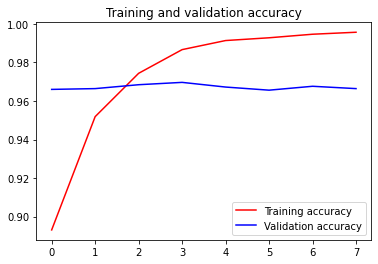

<Figure size 432x288 with 0 Axes>

In [28]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

for value in history.history:
    print(value, history.history[value])

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.figure()


plt.show()